# Denoising: Wavelet-Based Destriping

Thermal remote sensing often uses this approach.
- Discrete Wavelet Transform
- Suppress stripe components in horizontal/vertical high-frequency bands
- Reconstruct the image

In [80]:
# try denoising using wavlet or non-local means filters
import pywt
import numpy as np
import cv2


def wavelet_destripe(img, **kwargs):
    coeffs2 = pywt.dwt2(img, 'db3')
    LL, (LH, HL, HH) = coeffs2

    HL = HL.astype(np.float32)
    LH = LH.astype(np.float32)
    # Remove vertical stripes in HL (vertical detail)
    HL = cv2.medianBlur(HL, 5)

    # Remove horizontal stripes in LH
    LH = cv2.medianBlur(LH, 5)

    img_recon = pywt.idwt2((LL, (LH, HL, HH)), 'db3')
    return np.clip(img_recon, 0, 1)

In [85]:
# Define Dataset and DataLoader with Albumentations transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import functional as F
import os
import torch
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2


class YoloDetectionDataset(Dataset):
    """Dataset wrapper that reads YOLO-format labels and returns torchvision targets."""

    def __init__(self, images_dir, class_count, transforms=None):
        self.images_dir = images_dir
        self.labels_dir = os.path.join(os.path.dirname(images_dir), "labels")
        self.class_count = class_count
        self.transforms = transforms

        if not os.path.isdir(self.images_dir):
            raise FileNotFoundError(
                f"Images directory not found: {self.images_dir}")
        if not os.path.isdir(self.labels_dir):
            raise FileNotFoundError(
                f"Labels directory not found: {self.labels_dir}")

        exts = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}
        self.samples = []
        for file_name in sorted(os.listdir(self.images_dir)):
            if os.path.splitext(file_name)[1].lower() not in exts:
                continue
            image_path = os.path.join(self.images_dir, file_name)
            label_path = os.path.join(
                self.labels_dir, os.path.splitext(file_name)[0] + ".txt")
            self.samples.append((image_path, label_path))

        if not self.samples:
            raise RuntimeError(f"No image files detected in {self.images_dir}")

    def __len__(self):
        """Return the number of image/label pairs available."""
        return len(self.samples)

    def __getitem__(self, idx):
        """Load a sample and convert YOLO boxes to absolute XYXY tensors. Supports Albumentations transforms."""
        image_path, label_path = self.samples[idx]
        image = self._load_image(image_path)

        height, width = image.shape[1], image.shape[2]

        boxes = []
        labels = []
        if os.path.isfile(label_path):
            with open(label_path, "r", encoding="utf-8") as f:
                for line in f:
                    line = line.strip()
                    if not line:
                        continue
                    parts = line.split()
                    if len(parts) != 5:
                        continue
                    cls, xc, yc, w, h = map(float, parts)
                    cls = int(cls)
                    if cls < 0 or cls >= self.class_count:
                        continue
                    box = self._yolo_to_xyxy(xc, yc, w, h, width, height)
                    if box is None:
                        continue
                    boxes.append(box)
                    labels.append(cls + 1)

        # Albumentations expects boxes as list of [x_min, y_min, x_max, y_max] and labels as list
        if self.transforms is not None:
            # Albumentations expects HWC numpy image
            np_image = image.permute(1, 2, 0).cpu().numpy()  # CHW to HWC
            # If no boxes, pass empty list
            transformed = self.transforms(
                image=np_image,
                bboxes=boxes,
                labels=labels
            )
            # Convert back to torch tensor (C, H, W)
            image = transformed["image"]
            boxes = transformed["bboxes"]
            labels = transformed["labels"]

        # Convert boxes and labels to tensors
        if boxes:
            boxes = torch.tensor(boxes, dtype=torch.float32)
            labels = torch.tensor(labels, dtype=torch.int64)
            area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
        else:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
            area = torch.zeros((0,), dtype=torch.float32)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([idx], dtype=torch.int64),
            "area": area,
            "iscrowd": torch.zeros((labels.shape[0],), dtype=torch.int64),
        }

        return image, target

    @staticmethod
    def _yolo_to_xyxy(xc, yc, w, h, width, height):
        """Convert normalized YOLO coordinates into absolute XYXY pixel positions."""
        x1 = (xc - w / 2.0) * width
        y1 = (yc - h / 2.0) * height
        x2 = (xc + w / 2.0) * width
        y2 = (yc + h / 2.0) * height

        x1 = max(0.0, min(x1, width))
        y1 = max(0.0, min(y1, height))
        x2 = max(0.0, min(x2, width))
        y2 = max(0.0, min(y2, height))

        if x2 <= x1 or y2 <= y1:
            return None
        return [x1, y1, x2, y2]

    @staticmethod
    def _load_image(path):
        """Read image or numpy array and return a contiguous CHW float tensor in [0,1]."""
        with Image.open(path) as img:
            # Convert to RGB
            img = img.convert("RGB")
            tensor = F.to_tensor(img)  # C, H, W in [0,1]   
            
        return tensor.contiguous()

In [86]:
# Define Albumentations transforms for training
train_transforms = A.Compose([
    A.RandomRotate90(),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.Affine(scale=(0.8, 1.2), shear=(-5, 5),
             translate_percent=(0.0, 0.1), p=0.6),
    A.OneOf([
            A.GaussianBlur(blur_limit=(1, 3), p=0.4),
            A.MotionBlur(blur_limit=3, p=0.2),
            A.NoOp()
            ], p=0.4),
    A.RandomBrightnessContrast(
        brightness_limit=0.02, contrast_limit=0.02, p=0.5),  # small
    # A.GaussNoise(p=0.4),
    # custom: gain/offset jitter (implement as lambda if needed)
    # denoising step
    A.Normalize(mean=0.0, std=1.0, max_pixel_value=1.0),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

val_transforms = A.Compose(
    [
    A.Normalize(mean=0.0, std=1.0, max_pixel_value=1.0),
    ToTensorV2()]
)

In [87]:
import yaml


def resolve_path(base_dir, relative_path):
    """Resolve dataset paths regardless of whether they are absolute or relative."""
    if os.path.isabs(relative_path):
        return relative_path
    return os.path.normpath(os.path.join(base_dir, relative_path))


def load_dataset_paths(data_yaml):
    """Load train/val directories and class count from a YOLO `data.yaml`."""
    with open(data_yaml, "r", encoding="utf-8") as f:
        config = yaml.safe_load(f)
    base_dir = os.path.dirname(os.path.abspath(data_yaml))
    dataset_root = config.get("path", "")
    if dataset_root:
        dataset_root = resolve_path(base_dir, dataset_root)
    train_images = resolve_path(
        dataset_root, config["train"]) if dataset_root else resolve_path(base_dir, config["train"])
    val_key = config.get("val", None)
    val_images = None
    if val_key:
        val_images = resolve_path(
            dataset_root, val_key) if dataset_root else resolve_path(base_dir, val_key)
    class_count = int(config["nc"])
    return train_images, val_images, class_count

In [88]:
def collate_fn(batch):
    """Custom collate function to keep images and targets in list form."""
    images, targets = zip(*batch)
    return list(images), list(targets)

In [89]:
train_images, val_images, class_count = load_dataset_paths("faster_rcnn.yaml")

# load images and labels, create datasets and dataloaders as needed
# only take validation data, because training images may have no waterfowl
val_dataset = YoloDetectionDataset(
    val_images, class_count, transforms=val_transforms)
val_loader = DataLoader(
    val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

In [90]:
# load original training image, and compute the mean and stddev for normalization
train_dataset = YoloDetectionDataset(
    train_images, class_count, transforms=val_transforms)


# iterate through training dataset to compute mean and stddev
sum_channels = torch.zeros(3)
sum_squared_channels = torch.zeros(3)
num_pixels = 0
for img, _ in train_dataset:
    c, h, w = img.shape
    num_pixels += h * w
    sum_channels += img.sum(dim=(1, 2))
    sum_squared_channels += (img ** 2).sum(dim=(1, 2))
mean = sum_channels / num_pixels
stddev = torch.sqrt((sum_squared_channels / num_pixels) - (mean ** 2))
print(f"Computed training dataset mean: {mean}")
print(f"Computed training dataset stddev: {stddev}")

Computed training dataset mean: tensor([0.4087, 0.4087, 0.4087])
Computed training dataset stddev: tensor([0.1476, 0.1476, 0.1476])


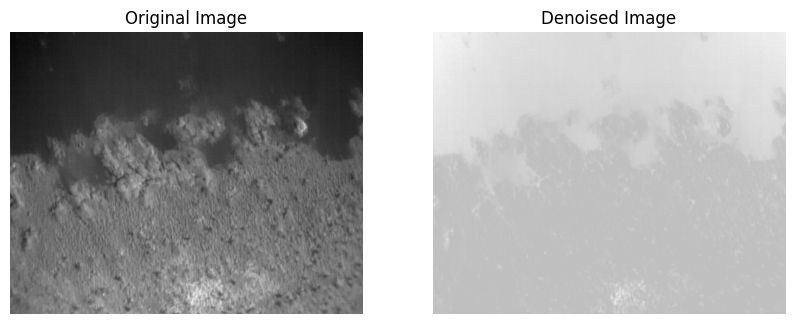

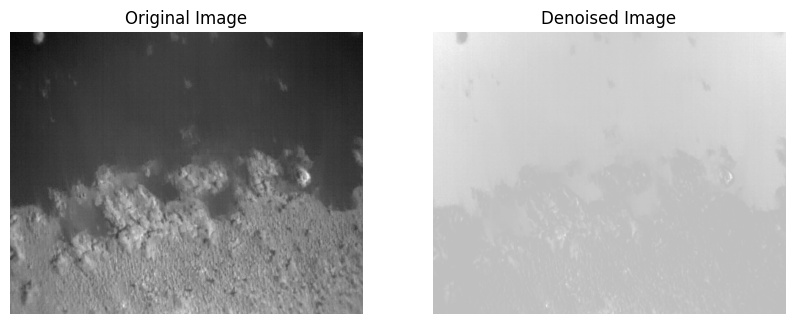

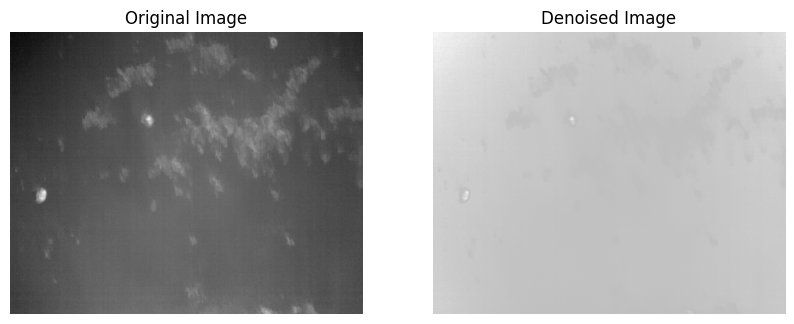

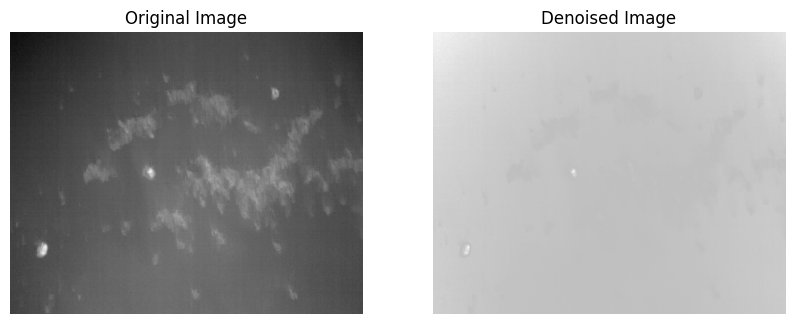

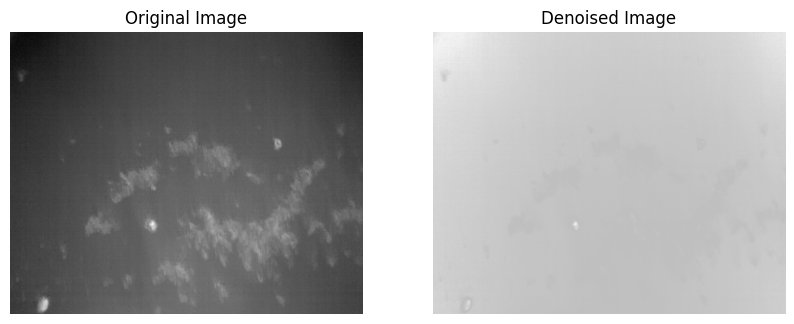

In [ ]:
# visualize denoising effect
import matplotlib.pyplot as plt
# example usage
for _ in range(5):
    sample_img, _ = train_dataset[_]
    sample_img = sample_img.permute(1, 2, 0).cpu().numpy()  # CHW to HWC
    # only take one channel for denoising
    sample_img = sample_img[:, :, 0]
    denoised_img = wavelet_destripe(sample_img)
    # normalize to mean=0, stddev=1 using computed values
    # denoised_img = (denoised_img - mean.numpy()) / stddev.numpy()

    # normalize denoised image
    # visualize original and denoised images as needed
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(sample_img)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.title("Denoised Image")
    plt.imshow(denoised_img)
    plt.axis('off')
    plt.show()

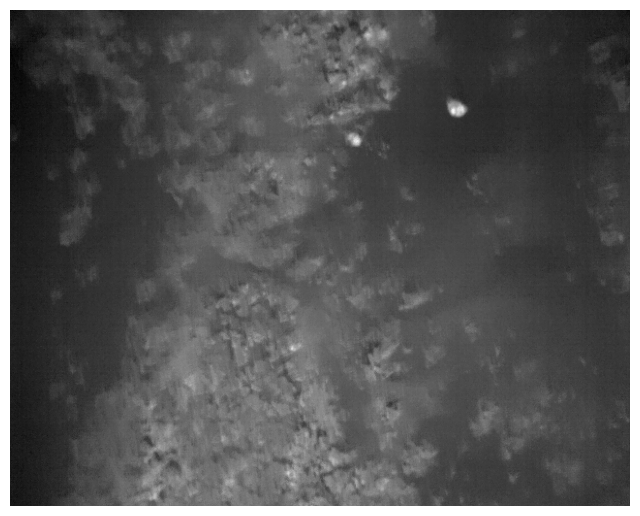

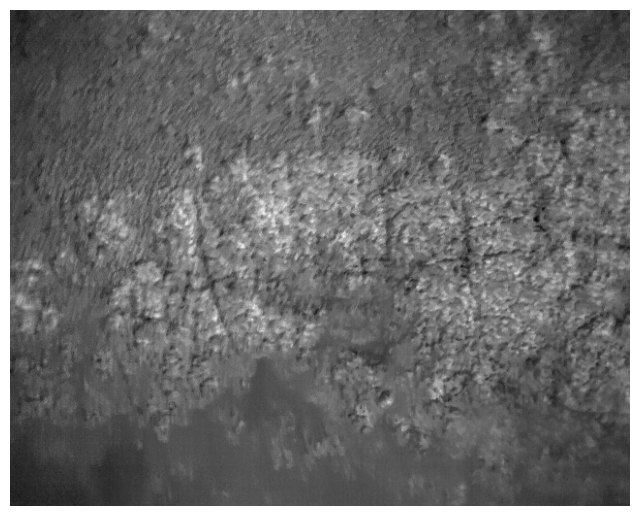

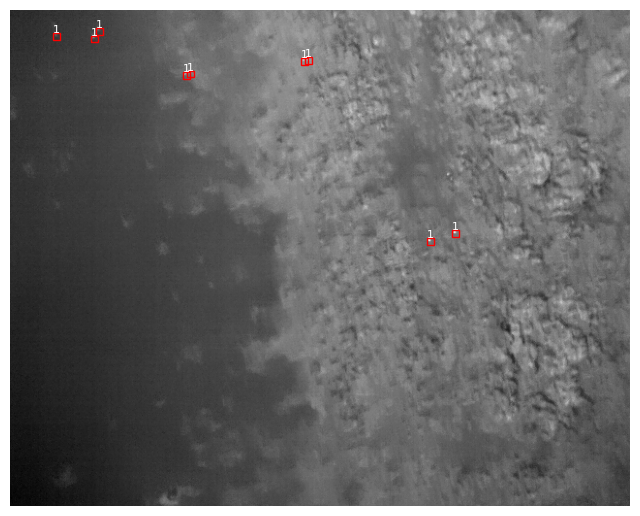

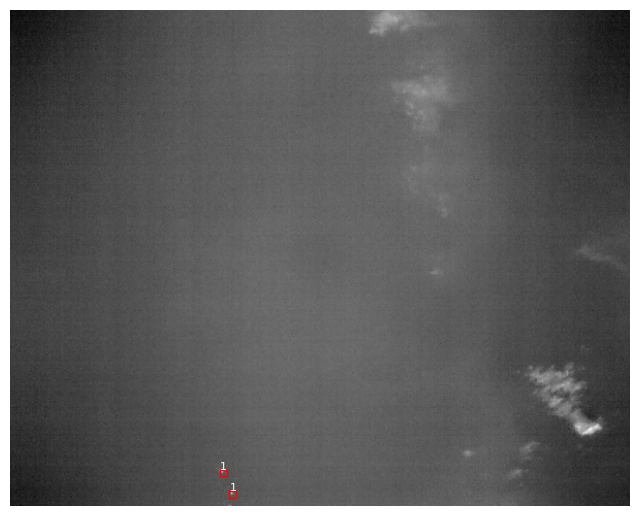

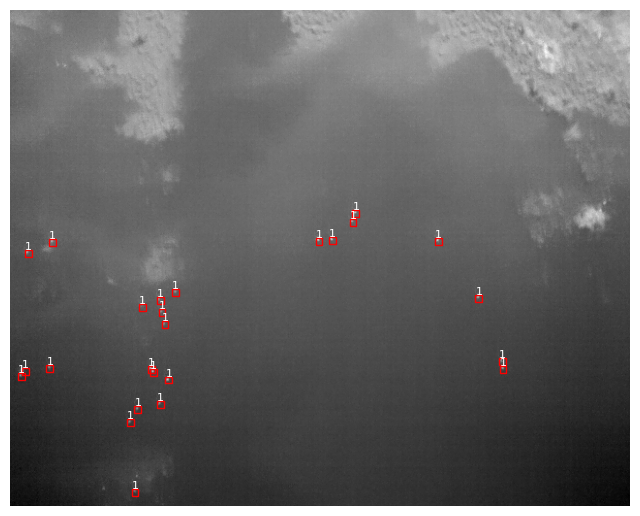

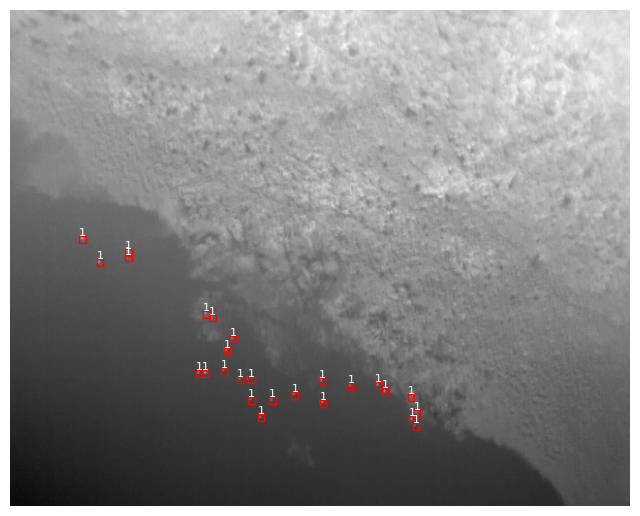

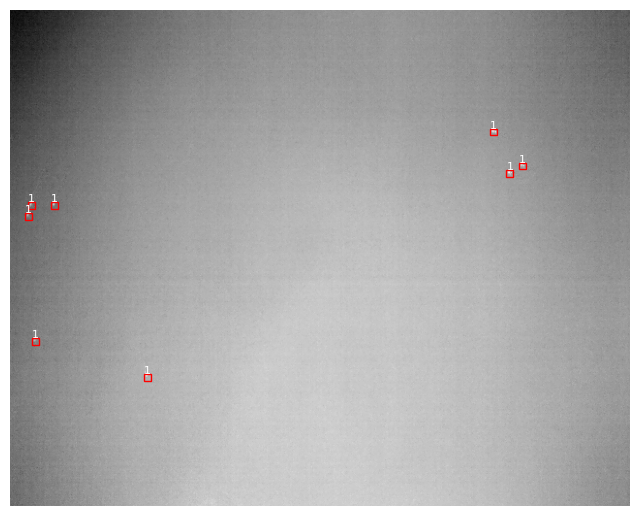

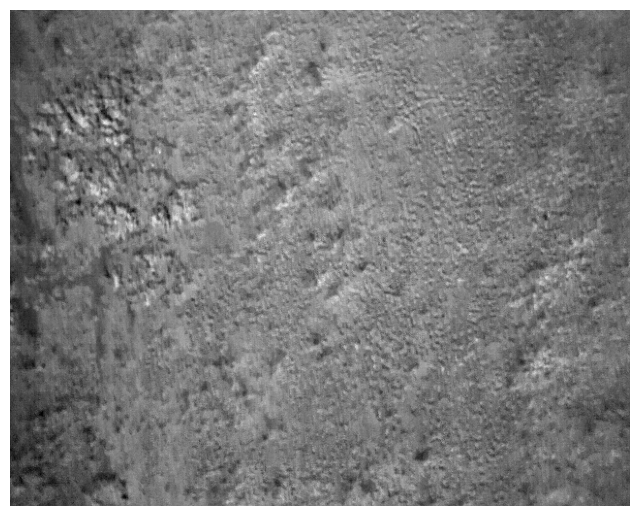

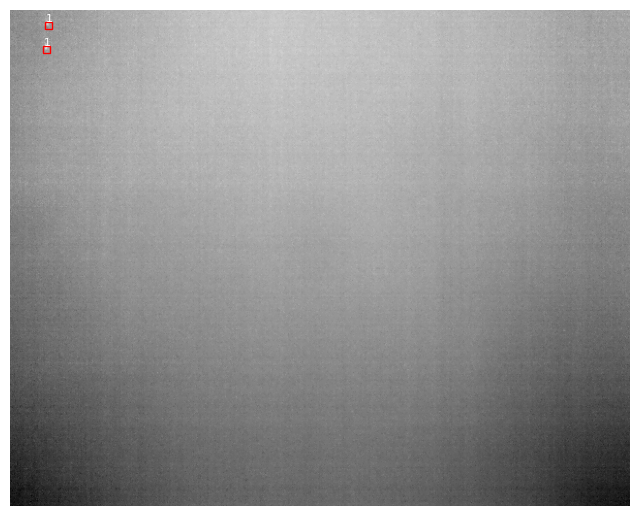

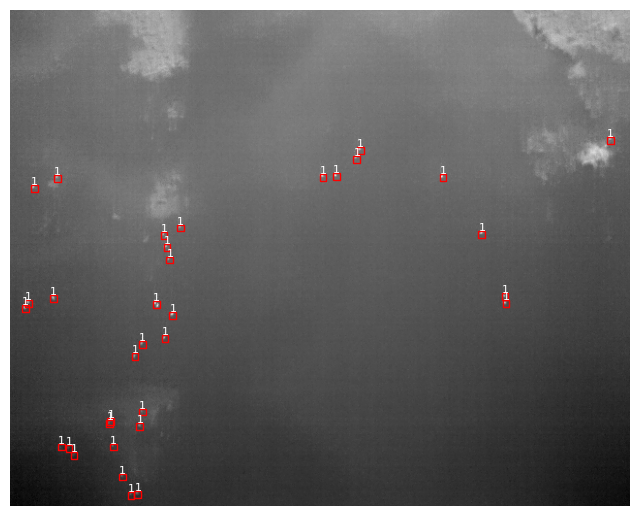

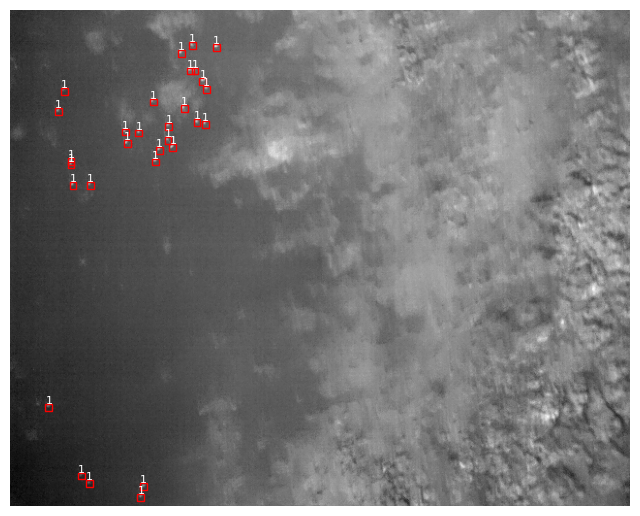

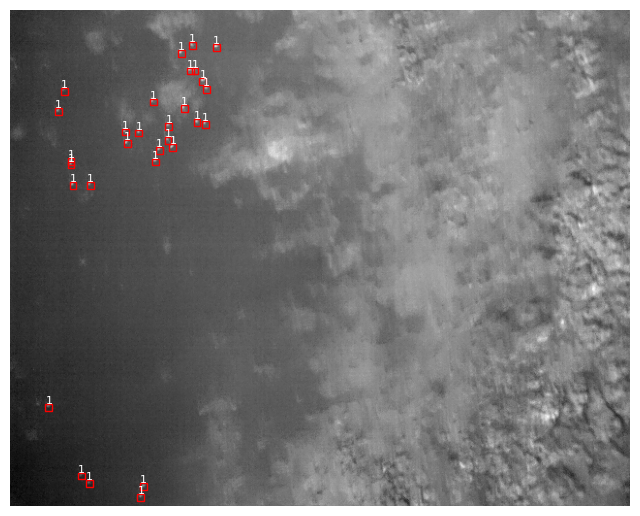

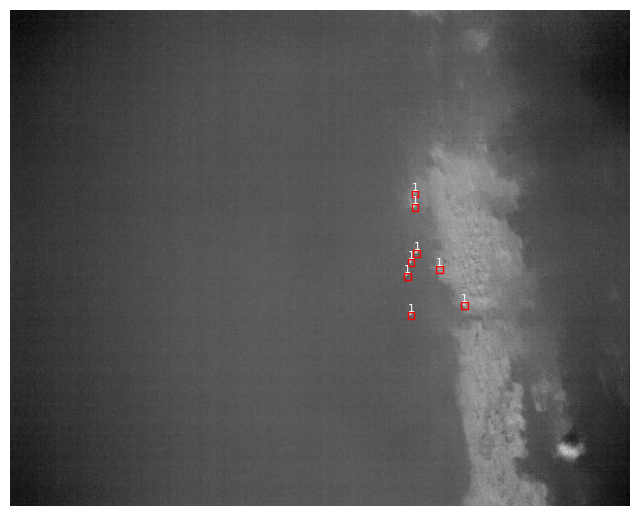

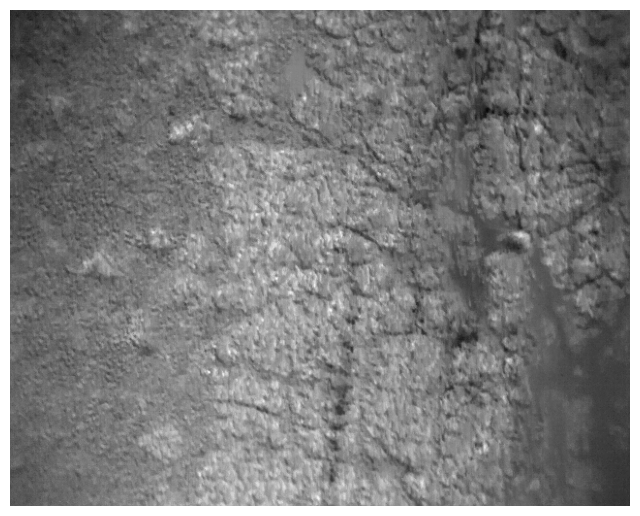

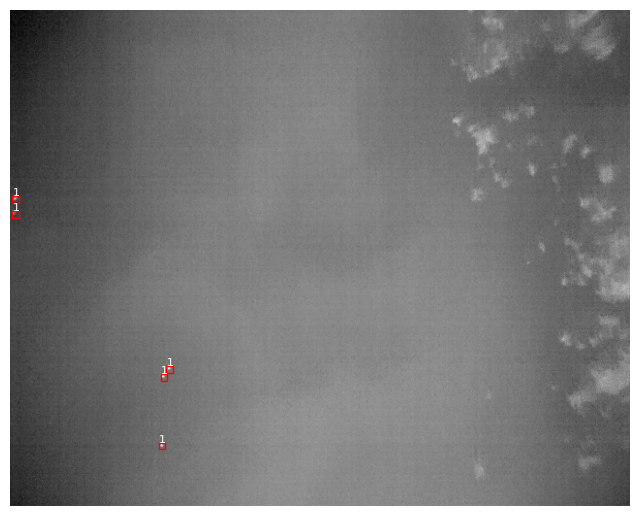

In [92]:
# show some samples with augmentations applied
import matplotlib.pyplot as plt
import random

# show 5 random samples from the validation dataset
for _ in range(15):
    idx = random.randint(0, len(val_dataset) - 1)
    image, target = val_dataset[idx]
    boxes = target["boxes"].numpy()
    labels = target["labels"].numpy()

    # # raise error if no boxes found
    # if boxes.shape[0] == 0:
    #     raise RuntimeError(f"No boxes found in sample index {idx}")

    # Convert tensor image to numpy for plotting
    np_image = image.permute(1, 2, 0).cpu().numpy()

    plt.figure(figsize=(8, 8))
    plt.imshow(np_image)
    ax = plt.gca()

    for box, label in zip(boxes, labels):
        x1, y1, x2, y2 = box
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                             fill=False, color='red', linewidth=1)
        ax.add_patch(rect)
        ax.text(x1, y1, str(label.item()), fontsize=8,
                color='white', bbox=dict(facecolor='red', alpha=0))

    plt.axis('off')
    plt.show()